# Deterministic Model 02: Model parameters

In [1]:
# install libraries
#%pip install pandas
#%pip install numpy

In [2]:
# import pandas library
import pandas as pd
import numpy as np

### Read Data

In [3]:
# Read the file and assign it to variable "df_real"
other_path = '../../data/sim/merged_data.csv'
df = pd.read_csv(other_path, header=0)

In [4]:
# show the first 5 rows using dataframe.head() method
print('The first 5 rows of the dataframe')
df.head(5)

The first 5 rows of the dataframe


,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44


### Setting parameters of Robotic System

In [5]:
# robotics specification
speed_max_load = 0.5    # m/sec, speed TCP with load
speed_max_unload = 1.0  # m/sec, speed TCP without load
accel = 1               # m/sec2, acceleration TCP

time_to_max_load_speed = speed_max_load / accel
dist_to_max_load_speed = (1/2) * accel * time_to_max_load_speed

time_to_max_unload_speed = speed_max_unload / accel
dist_to_max_unload_speed = (1/2) * accel * time_to_max_unload_speed



range_max = 3_904       # mm, working max range
range_min = 1_912       # mm, working min range (aproximate

# brick robots specification
time_suck_on = 1.5          # sec
time_suck_off = 0.5         # sec
time_verif_refer = 3.5      # sec
time_refer_pallete = 2.1    # sec

# coordinates of reference point
refer_x = 500           # mm in coordinate system
refer_y = 2_450         # mm in coordinate system
refer_z = 1_500         # mm in coordinate system

# position of robotic arm
robot_x = 2_250         # mm in coordinate system
robot_y = 2_420         # mm in coordinate system
robot_z = 1_000         # mm in coordinate system

# parameters of simulation
grid_simulation = 100    # mm, grid simulation

### Calculation based on real data

In [6]:
# average time from pallete to verification table
time_pallete_verif = df['start_to_verif'].mean() + time_suck_on
time_pallete_verif


9.705479452054794

### Simulate total cycle time

In [7]:
def simulate_time(dist):
    total_time = time_suck_on + time_pallete_verif
    total_time += time_suck_off + time_suck_on + time_verif_refer
    total_time += (dist - dist_to_max_load_speed) / 1_000 / speed_max_load
    total_time += time_suck_off + time_refer_pallete
    total_time += (dist - dist_to_max_unload_speed) / 1_000 / speed_max_unload
    total_time += time_to_max_load_speed + time_to_max_unload_speed
    return total_time

In [8]:
df['total_time_sim'] = df.apply(lambda x : simulate_time(x['dist']) , axis=1)
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_sim
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40,28.997479
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38,28.592479
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36,27.854479
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36,26.216479
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44,25.166479


### Correcting Simulation time

In [9]:
koeff_correction = df['total_time'].mean() / df['total_time_sim'].mean()
df['total_time_sim'] = df['total_time_sim'] * koeff_correction

In [10]:
df.head()

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_sim
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40,41.163113
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38,40.588199
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36,39.540578
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36,37.215369
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44,35.724851


### Checking linear distance from reference to wall

In [11]:
# coordinates of reference point
df['dist_linear'] = ((df['x'] - refer_x)**2 + (df['y'] - refer_y)**2 + ((df['z']+250) - refer_z)**2)**(1/2)
df.head(10)

,id,type_brick,type,rotation,x,y,z,layer,pallet,dist,start_to_verif,verif_to_dest,dest_to_end,total_time,total_time_sim,dist_linear
0,1,CORNER,2,90,220,95,0,1,1,2731,6,18,16,40,41.163113,2680.844083
1,2,HALF,3,90,220,252,0,1,1,2596,4,16,18,38,40.588199,2544.033019
2,4,BASIC,1,90,220,690,0,1,2,2350,6,14,16,36,39.540578,2176.809592
3,6,BASIC,1,90,220,1190,0,1,4,1804,6,14,16,36,37.215369,1796.802716
4,9,BASIC,1,90,220,1940,0,1,7,1454,8,12,24,44,35.724851,1378.767566
5,13,BASIC,1,90,220,2940,0,1,11,1532,8,12,26,46,36.057024,1371.495534
6,21,END,4,0,565,220,0,1,1,2626,6,18,22,46,40.715958,2557.269051
7,23,BASIC,1,0,1065,220,0,1,20,2576,8,20,18,46,40.503026,2618.133877
8,24,BASIC,1,0,1315,220,0,1,21,2642,10,16,18,44,40.784096,2683.211695
9,25,BASIC,1,0,1565,220,0,1,22,2729,6,18,20,44,41.154596,2769.408782


### Comparing real and simulate data

In [12]:
#%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='type_brick', ylabel='total_time'>

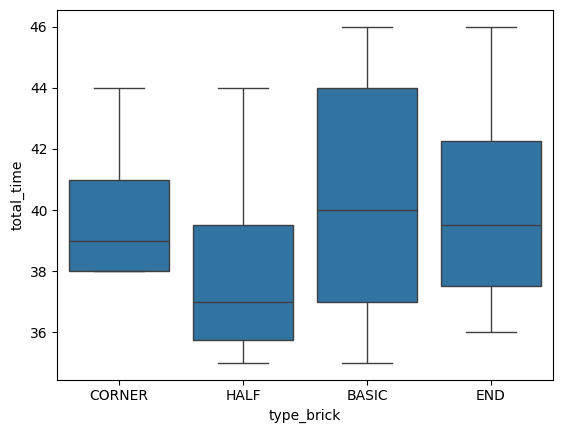

In [13]:
sns.boxplot(x='type_brick', y="total_time", data=df)

<Axes: xlabel='type_brick', ylabel='total_time_sim'>

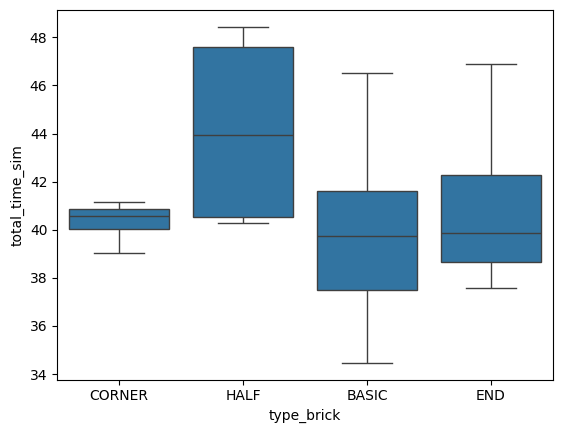

In [14]:
sns.boxplot(x='type_brick', y="total_time_sim", data=df)

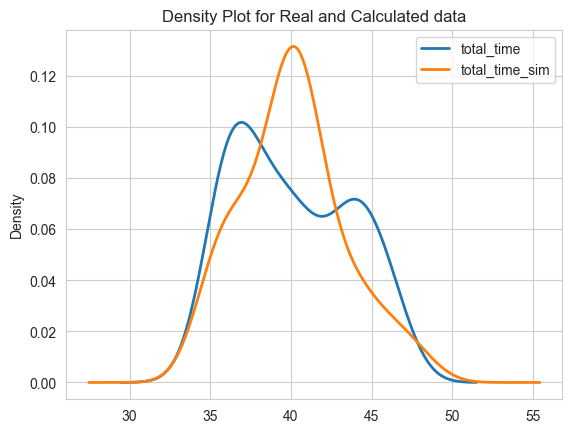

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot density
df[['total_time','total_time_sim']].plot.density(bw_method='scott', linestyle='-', linewidth=2)
plt.title('Density Plot for Real and Calculated data')
plt.show()

### Generate polar grid inside working range

In [16]:
# genereate points inside cubic space with side (range_max + range_max):

points = []

for x in range(-range_max, range_max, grid_simulation):
    for y in range(-range_max, range_max, grid_simulation):
        for z in range(-range_max, range_max, grid_simulation):
            points.append([x + robot_x,
                           y + robot_y,
                           z + robot_z])

print("Number of grid points:", len(points))

Number of grid points: 493039


In [17]:
df_point = pd.DataFrame(
    data=points,
    columns=['x', 'y', 'z']
)
df_point.head()

,x,y,z
0,-1654,-1484,-2904
1,-1654,-1484,-2804
2,-1654,-1484,-2704
3,-1654,-1484,-2604
4,-1654,-1484,-2504


In [18]:
df_point.to_csv("../../data/points/all_points.csv", index=False, header=False)

### Simulation allowed points in Rhino + Grasshopper

In [19]:
# Read the file and assign it to variable "df_allowed_point"
other_path = '../../data/points/allowed_points.csv'
df_allowed_points = pd.read_csv(other_path, header=0)

In [20]:
df_allowed_points[['x','y','z']] = df_allowed_points[['x','y','z']].astype(int)
df_allowed_points.head(5)


,x,y,z
0,2250,2420,637
1,2250,2420,1362
2,2250,2420,8
3,2250,2420,1005
4,2250,2420,316


### Generate simulation deterministic data

In [21]:
df_sim = df_allowed_points
df_sim['dist'] = ((df_sim['x'] - refer_x)**2 + (df_sim['y'] - refer_y)**2 + ((df_sim['z']+250) - refer_z)**2)**(1/2)
df_sim['total_time'] = df_sim.apply(lambda x : simulate_time(x['dist']) , axis=1)
df_sim['total_time'] = df_sim['total_time'] * koeff_correction
df_sim.head()

,x,y,z,dist,total_time
0,2250,2420,637,1854.499663,37.430428
1,2250,2420,1362,1753.836937,37.001744
2,2250,2420,8,2146.150973,38.672461
3,2250,2420,1005,1767.321420,37.059169
4,2250,2420,316,1983.873988,37.981385


In [22]:
df_sim.describe()

,x,y,z,dist,total_time
count,15286.000000,15286.000000,15286.000000,15286.000000,15286.000000
mean,2250.777836,2418.592699,1139.165511,2380.843122,39.671927
std,1112.325139,1116.302229,1026.482860,973.126540,4.144179
min,-1633.000000,-1455.000000,0.000000,210.161842,30.427813
25%,2250.000000,2420.000000,435.250000,1781.114749,37.117910
50%,2250.000000,2420.000000,870.000000,1937.514129,37.783956
75%,2250.000000,2420.000000,1307.000000,2583.208082,40.533723
max,6125.000000,6283.000000,4736.000000,5656.253619,53.620666


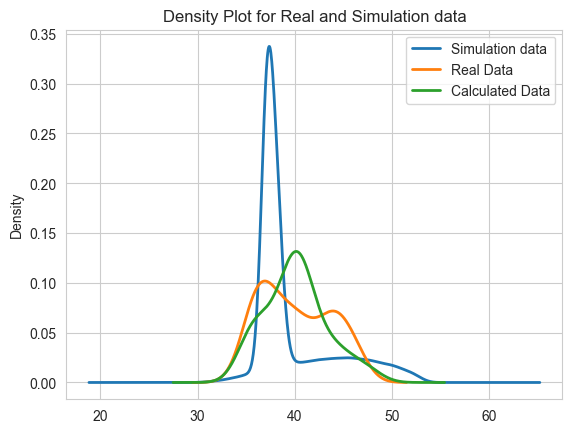

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot density
df_sim['total_time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Simulation data')
df['total_time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Real Data')
df['total_time_sim'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Calculated Data')
plt.title('Density Plot for Real and Simulation data')
plt.legend()
plt.show()

<h2>Save Dataset</h2>
<p>
Correspondingly, Pandas enables us to save the dataset to csv. By using the <code>dataframe.to_csv()</code> method, you can add the file path and name along with quotation marks in the brackets.
</p>
<p>
For example, if you would save the dataframe <b>df</b> as <b>automobile.csv</b> to your local machine, you may use the syntax below, where <code>index = False</code> means the row names will not be written.
</p>


In [24]:
df_sim.to_csv("../../data/sim/model_data.csv", index=False)

We can also read and save other file formats. We can use similar functions like **`pd.read_csv()`** and **`df.to_csv()`** for other data formats. The functions are listed in the following table:


#### Author/Date/Organization

Vjaceslav Usmanov, CTU in Prague

###### Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2026-01-20 | 1.1 | Vjaceslav Usmanov| added DM_02_Model_Parameters.ipynb |
| 2026-02-12 | 1.2 | Vjaceslav Usmanov| changed DM_02_Model_Parameters.ipynb |